# DSMarket - Forecasting

## Instalacion de paquetes

In [1]:
!pip install statsmodels
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Importamos librerias necesarias

In [2]:
import pandas as pd
import os
import numpy as np
import statsmodels
import re
import pickle

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from typing import Callable, List, Dict, Union

## 1. Cargamos fichero de datos

In [3]:
df = pd.read_parquet("df_forecasting.parquet", engine="pyarrow")
print(df.shape)
df.head(3)

(8354260, 14)


,id,item,category,department,store,store_code,region,yearweek,n_sales,revenue,avg_sell_price,event,cluster_store,cluster_item
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201105,0,0.0,12.7414,Without event,3,0
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201106,0,0.0,12.7414,SuperBowl,3,0
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201107,0,0.0,12.7414,Valentine's Day,3,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              object 
 1   item            object 
 2   category        object 
 3   department      object 
 4   store           object 
 5   store_code      object 
 6   region          object 
 7   yearweek        int64  
 8   n_sales         int64  
 9   revenue         float64
 10  avg_sell_price  float64
 11  event           object 
 12  cluster_store   int32  
 13  cluster_item    int32  
dtypes: float64(2), int32(2), int64(2), object(8)
memory usage: 828.6+ MB


In [5]:
series = df["yearweek"].nunique()
print("Cantidad de series temporales: ", series)

Cantidad de series temporales:  274


In [6]:
first_week = df["yearweek"].min()
last_week = df["yearweek"].max()
print(f"Semana inicial es {first_week}\nSemana final es {last_week}")

Semana inicial es 201105
Semana final es 201617


## 3. Validacion de nulos

In [7]:
def contar_nulos(*dataframes):
    """
    Cuenta los valores nulos, la cantidad de registros por columna y el porcentaje
    de nulos para cada DataFrame proporcionado.
    """
    for i, df in enumerate(dataframes):
        print(f"\nAnálisis del DataFrame {i+1}:")
        null_counts = df.isnull().sum()
        total_counts = df.shape[0]
        null_percentage = (null_counts / total_counts) * 100

        null_info_df = pd.DataFrame({
            'Cantidad Registros': total_counts,
            'Cantidad Nulos': null_counts,
            '% Nulos': null_percentage
        })

        # Mostrar la información para cada columna
        print(null_info_df[null_info_df['Cantidad Nulos'] > 0])

In [8]:
contar_nulos(df)


Análisis del DataFrame 1:
Empty DataFrame
Columns: [Cantidad Registros, Cantidad Nulos, % Nulos]
Index: []


## 4. EDA

### Creacion de fecha para cada semana-año

In [9]:
# Asegurar tipos
df["yearweek"] = df["yearweek"].astype(str)

# Universo de semanas ISO en el rango
weeks_all = sorted(df["yearweek"].unique())
weeks_df = pd.DataFrame(weeks_all, columns=["yearweek"])

# Mapear yearweek → fecha fin de semana (lunes-based ISO) tomamos el lunes de la semana:
def iso_yearweek_to_date(yw):
    year = int(yw[:4]); week = int(yw[4:])
    # ISO: lunes de esa semana
    return pd.to_datetime(f"{year}-W{str(week).zfill(2)}-1", format="%G-W%V-%u")

weeks_df["date"] = weeks_df["yearweek"].map(iso_yearweek_to_date)

In [10]:
weeks_df

,yearweek,date
0,201105,2011-01-31
1,201106,2011-02-07
2,201107,2011-02-14
3,201108,2011-02-21
4,201109,2011-02-28
...,...,...
269,201613,2016-03-28
270,201614,2016-04-04
271,201615,2016-04-11
272,201616,2016-04-18


In [11]:
df = df.merge(weeks_df, on='yearweek', how='left')
df.head(3)

,id,item,category,department,store,store_code,region,yearweek,n_sales,revenue,avg_sell_price,event,cluster_store,cluster_item,date
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201105,0,0.0,12.7414,Without event,3,0,2011-01-31
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201106,0,0.0,12.7414,SuperBowl,3,0,2011-02-07
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201107,0,0.0,12.7414,Valentine's Day,3,0,2011-02-14


### EDA total ventas

In [12]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax = ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)

In [13]:
y = df.set_index("date").resample("W")["n_sales"].sum()

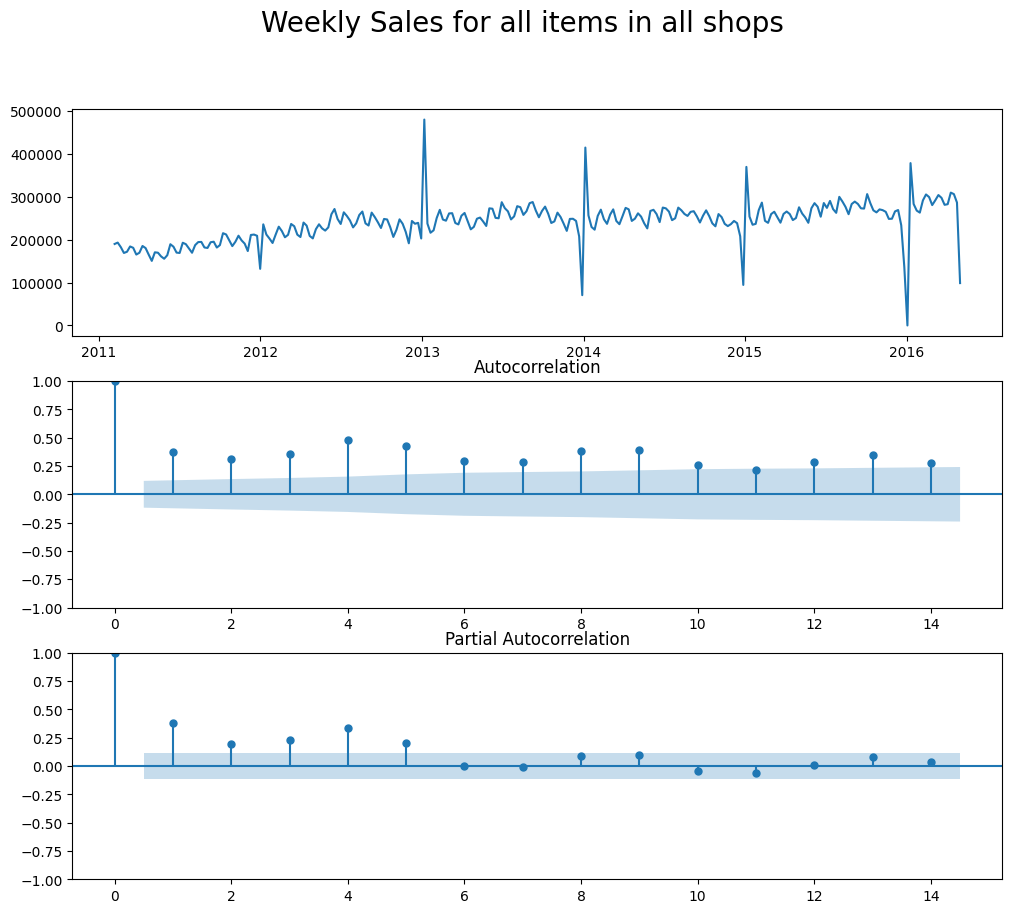

In [14]:
plot_ts_acf_pacf(y = y, title = "Weekly Sales for all items in all shops");

### EDA tiendas

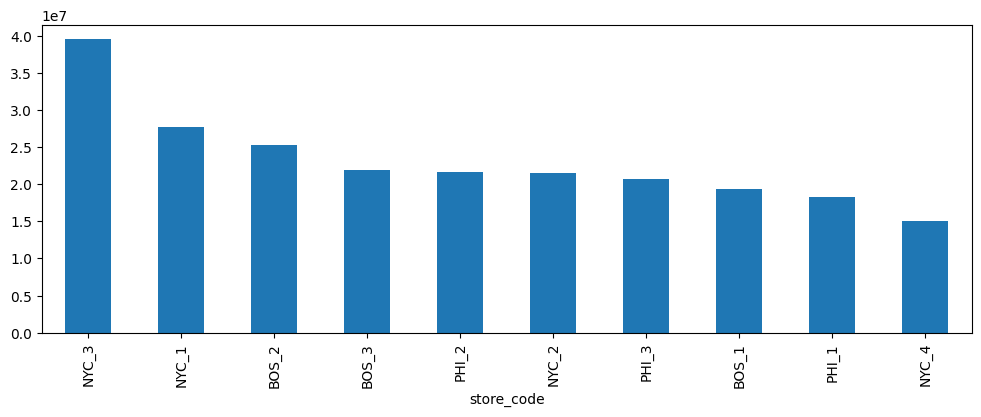

In [15]:
(
    df.
    groupby(["store_code"])
    ["revenue"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

### EDA departments

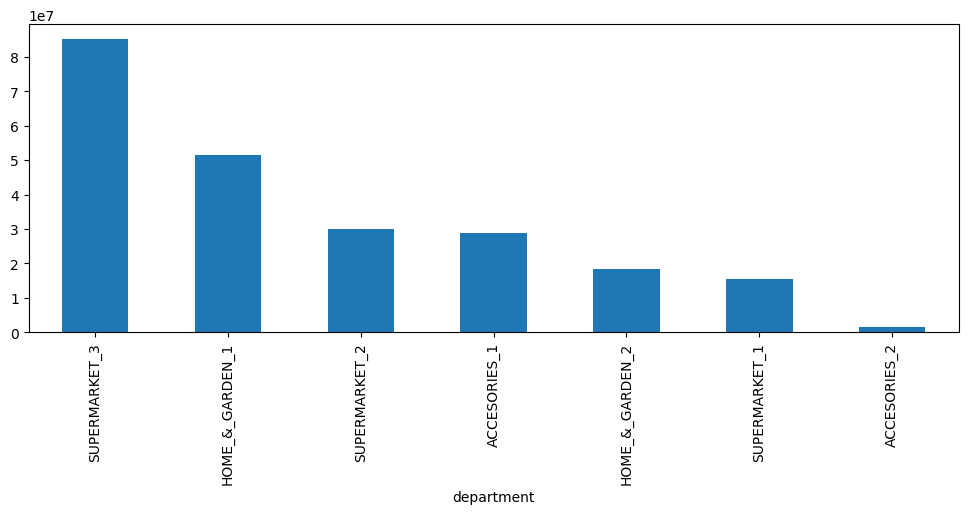

In [16]:
(
    df.
    groupby(["department"])
    ["revenue"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

### EDA categories

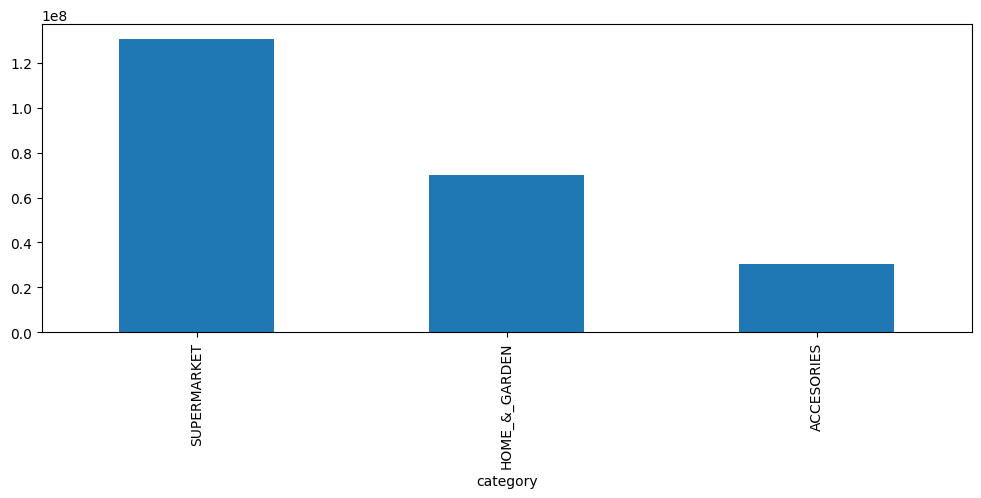

In [17]:
(
    df.
    groupby(["category"])
    ["revenue"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

## 5. Tratamiento variables categoricas

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 15 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              object        
 1   item            object        
 2   category        object        
 3   department      object        
 4   store           object        
 5   store_code      object        
 6   region          object        
 7   yearweek        object        
 8   n_sales         int64         
 9   revenue         float64       
 10  avg_sell_price  float64       
 11  event           object        
 12  cluster_store   int32         
 13  cluster_item    int32         
 14  date            datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int32(2), int64(1), object(9)
memory usage: 892.3+ MB


In [19]:
df_labels = df[["id", "item", "category", "department", "store", "store_code", "region"]].drop_duplicates().reset_index(drop=True)

Usamos ordinal encoder para asignar un id a cada categoria en variables categoricas

In [20]:
# columnas categóricas a codificar
cat_cols = ["item", "category", "department", "region", "store_code", "region"]

# inicializar encoder
enc = OrdinalEncoder(
    handle_unknown="use_encoded_value",  # no fallar si aparece categoría nueva en futuros datos
    unknown_value=-1,
    dtype=np.int64
)

# ajustamos y transformamos en el mismo df
df[cat_cols] = enc.fit_transform(df[cat_cols]) + 1

### Variable 'event'

In [21]:
df["event"].value_counts(normalize=True) * 100

event
Without event              71.532847
SuperBowl                   2.189781
Valentine's Day             2.189781
St. Patrick's Day           2.189781
Easter                      2.189781
Mother's Day                1.824818
Father's Day                1.824818
Ramadan starts              1.824818
Small Business Saturday     1.824818
Labor Day                   1.824818
Halloween                   1.824818
Thanksgiving                1.824818
Super Saturday              1.824818
Green Monday                1.824818
NewYear                     1.824818
Independence Day            1.459854
Name: proportion, dtype: float64

In [22]:
df["event"] = np.where(df["event"] == "Without event", 0, 1)

In [23]:
df["event"].value_counts(normalize=True) * 100

event
0    71.532847
1    28.467153
Name: proportion, dtype: float64

In [24]:
cols_order = [
    "id", "item", "category", "department", "store_code", "region",
    "yearweek", "date", "event", "cluster_item", "cluster_store", "n_sales", "revenue", "avg_sell_price"
]

df = df[cols_order]

In [25]:
df.head(5)

,id,item,category,department,store_code,region,yearweek,date,event,cluster_item,cluster_store,n_sales,revenue,avg_sell_price
0,ACCESORIES_1_001_BOS_1,1,1,1,1,1,201105,2011-01-31,0,0,3,0,0.0,12.7414
1,ACCESORIES_1_001_BOS_1,1,1,1,1,1,201106,2011-02-07,1,0,3,0,0.0,12.7414
2,ACCESORIES_1_001_BOS_1,1,1,1,1,1,201107,2011-02-14,1,0,3,0,0.0,12.7414
3,ACCESORIES_1_001_BOS_1,1,1,1,1,1,201108,2011-02-21,0,0,3,0,0.0,12.7414
4,ACCESORIES_1_001_BOS_1,1,1,1,1,1,201109,2011-02-28,0,0,3,0,0.0,12.7414


## 6. Creacion dataframe a predecir

In [26]:
def future_yearweeks_df(last_week, weeks_predict: int, as_str: bool = True) -> pd.DataFrame:
    """
    Genera un DataFrame con las próximas `weeks_predict` semanas a partir de `last_week`.
    - last_week: 'YYYYWW' como str o int (p.ej. '201617' o 201617)
    - weeks_predict: cantidad de semanas futuras a generar
    - as_str: True => yearweek como string 'YYYYWW'; False => int
    """
    last_week = str(last_week)
    year = int(last_week[:4])
    week = int(last_week[4:])

    weeks = []
    for _ in range(weeks_predict):
        week += 1
        if week > 53:  # si llegara a existir W53, pasamos a W01 del año siguiente
            week = 1
            year += 1
        val = f"{year}{str(week).zfill(2)}"
        weeks.append(val if as_str else int(val))

    return pd.DataFrame({"yearweek": weeks})

### Determinar numero semanas a predecir

In [27]:
weeks_predict = 4
df_weeks_future = future_yearweeks_df(last_week, weeks_predict, as_str=True)

# Crear dataframe de ids únicos
df_ids = df[["id", "item", "category", "department", "store_code","region"]].drop_duplicates()

# Cross join de id's y semanas a predecir, obteniendo df_predict
try:
    # pandas 1.2+ soporta how='cross'
    df_predict = df_ids.merge(df_weeks_future, how="cross")
except TypeError:
    # fallback si tu pandas no soporta 'cross'
    df_ids["_k"] = 1
    df_weeks_future["_k"] = 1
    df_predict = df_ids.merge(df_weeks_future, on="_k").drop(columns="_k")

# df_predict tiene columnas: id, yearweek, n_sales
print(df_predict.shape)
df_predict.head()

(121960, 7)


,id,item,category,department,store_code,region,yearweek
0,ACCESORIES_1_001_BOS_1,1,1,1,1,1,201618
1,ACCESORIES_1_001_BOS_1,1,1,1,1,1,201619
2,ACCESORIES_1_001_BOS_1,1,1,1,1,1,201620
3,ACCESORIES_1_001_BOS_1,1,1,1,1,1,201621
4,ACCESORIES_1_001_BOS_2,1,1,1,2,1,201618


### Asignar fecha a las nuevas semanas

In [28]:
# Asegurar tipos
df_predict["yearweek"] = df_predict["yearweek"].astype(str)

# Universo de semanas ISO en el rango
weeks_predict_all = sorted(df_predict["yearweek"].unique())
weeks_df_predict = pd.DataFrame(weeks_predict_all, columns=["yearweek"])

# Mapear yearweek → fecha fin de semana (lunes-based ISO) tomamos el lunes de la semana:
def iso_yearweek_to_date(yw):
    year = int(yw[:4]); week = int(yw[4:])
    # ISO: lunes de esa semana
    return pd.to_datetime(f"{year}-W{str(week).zfill(2)}-1", format="%G-W%V-%u")

weeks_df_predict["date"] = weeks_df_predict["yearweek"].map(iso_yearweek_to_date)

In [29]:
df_predict = df_predict.merge(weeks_df_predict, on='yearweek', how='left')
df_predict.head(3)

,id,item,category,department,store_code,region,yearweek,date
0,ACCESORIES_1_001_BOS_1,1,1,1,1,1,201618,2016-05-02
1,ACCESORIES_1_001_BOS_1,1,1,1,1,1,201619,2016-05-09
2,ACCESORIES_1_001_BOS_1,1,1,1,1,1,201620,2016-05-16


In [30]:
df_predict.shape

(121960, 8)

### Adicion de variables para las futuras semanas

In [31]:
df_predict["event"] = 0
df_predict["n_sales"] = 0
df_predict["revenue"] = 0
df_predict["avg_sell_price"] = 0

In [32]:
cluster_store = df[["store_code", "cluster_store"]].drop_duplicates()
cluster_item = df[["item", "cluster_item"]].drop_duplicates()

In [33]:
df_predict.shape

(121960, 12)

In [34]:
df_predict = (
    df_predict
    .merge(cluster_store, on="store_code", how="left")
    .merge(cluster_item, on="item", how="left")
)

In [35]:
df_predict.shape

(121960, 14)

In [36]:
df.head(3)

,id,item,category,department,store_code,region,yearweek,date,event,cluster_item,cluster_store,n_sales,revenue,avg_sell_price
0,ACCESORIES_1_001_BOS_1,1,1,1,1,1,201105,2011-01-31,0,0,3,0,0.0,12.7414
1,ACCESORIES_1_001_BOS_1,1,1,1,1,1,201106,2011-02-07,1,0,3,0,0.0,12.7414
2,ACCESORIES_1_001_BOS_1,1,1,1,1,1,201107,2011-02-14,1,0,3,0,0.0,12.7414


In [37]:
df_predict.head(3)

,id,item,category,department,store_code,region,yearweek,date,event,n_sales,revenue,avg_sell_price,cluster_store,cluster_item
0,ACCESORIES_1_001_BOS_1,1,1,1,1,1,201618,2016-05-02,0,0,0,0,3,0
1,ACCESORIES_1_001_BOS_1,1,1,1,1,1,201619,2016-05-09,0,0,0,0,3,0
2,ACCESORIES_1_001_BOS_1,1,1,1,1,1,201620,2016-05-16,0,0,0,0,3,0


In [38]:
df["yearweek"] = df["yearweek"].astype(int)
df_predict["yearweek"] = df_predict["yearweek"].astype(int)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 14 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              object        
 1   item            int64         
 2   category        int64         
 3   department      int64         
 4   store_code      int64         
 5   region          int64         
 6   yearweek        int64         
 7   date            datetime64[ns]
 8   event           int64         
 9   cluster_item    int32         
 10  cluster_store   int32         
 11  n_sales         int64         
 12  revenue         float64       
 13  avg_sell_price  float64       
dtypes: datetime64[ns](1), float64(2), int32(2), int64(8), object(1)
memory usage: 828.6+ MB


In [40]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121960 entries, 0 to 121959
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              121960 non-null  object        
 1   item            121960 non-null  int64         
 2   category        121960 non-null  int64         
 3   department      121960 non-null  int64         
 4   store_code      121960 non-null  int64         
 5   region          121960 non-null  int64         
 6   yearweek        121960 non-null  int64         
 7   date            121960 non-null  datetime64[ns]
 8   event           121960 non-null  int64         
 9   n_sales         121960 non-null  int64         
 10  revenue         121960 non-null  int64         
 11  avg_sell_price  121960 non-null  int64         
 12  cluster_store   121960 non-null  int32         
 13  cluster_item    121960 non-null  int32         
dtypes: datetime64[ns](1), int32(2), int6

### Union de df historico y df a predecir

In [41]:
rows_df = df.shape[0]
rows_predict = df_predict.shape[0]
total_rows = rows_df + rows_predict
print(f"Filas en df historico: {rows_df}")
print(f"Filas en df predecir: {rows_predict}")
print(f"Filas que deben resultar despues de union: {total_rows}")

Filas en df historico: 8354260
Filas en df predecir: 121960
Filas que deben resultar despues de union: 8476220


In [42]:
df = pd.concat([df, df_predict], ignore_index=True)

In [43]:
rows_df_concat = df.shape[0]
rows_validation = total_rows - rows_df_concat
print(f"Filas en df historico: {rows_df}")
print(f"Filas en df predecir: {rows_predict}")
print(f"Filas que deben resultar despues de union: {total_rows}")
print(f"Filas resultantes despues de union: {rows_df_concat}")
print(f"Diferencia de: {rows_validation}")

Filas en df historico: 8354260
Filas en df predecir: 121960
Filas que deben resultar despues de union: 8476220
Filas resultantes despues de union: 8476220
Diferencia de: 0


## 7. Creacion de features para time series

In [44]:
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name, nr_lags):

    assert "date" in df.columns.tolist(), "Date must be in df columns"

    new_name = "_".join(gb_list + [target_column, agg_func_name])

    # 1) Agregar a nivel semanal (date ya corresponde al lunes ISO)
    gb_df_ = (
        df.groupby(gb_list + ["date"], as_index=False)[target_column]
          .agg(agg_func)
          .rename(columns={target_column: new_name})
          .sort_values(gb_list + ["date"])
    )

    # 2) Crear lags semanales por cada grupo
    for lag in range(1, nr_lags + 1):
        gb_df_[f"{new_name}_lag{lag}"] = (
            gb_df_.groupby(gb_list, sort=False)[new_name].shift(lag)
        )

    # 4) Evitar target leakage
    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(columns=[new_name], inplace=True)

    return gb_df_

In [45]:
def _resolve_agg_func(agg_func: Union[str, Callable]) -> Union[str, Callable]:
    if isinstance(agg_func, str):
        return agg_func.lower()  # "sum", "mean", etc.
    if callable(agg_func):
        # 🔽 Mapea np.sum → "sum", np.mean → "mean", etc.
        lut = {"sum": "sum", "mean": "mean", "max": "max", "min": "min", "median": "median"}
        name = getattr(agg_func, "__name__", "")
        if name in lut:
            return lut[name]
        return agg_func  # callables raros se devuelven tal cual
    raise ValueError(f"agg_func inválido: {agg_func}")

def _resolve_agg_name(agg_func: Union[str, Callable], agg_func_name: str) -> str:
    if agg_func_name:
        return agg_func_name
    if isinstance(agg_func, str):
        return agg_func.lower()
    if callable(agg_func) and getattr(agg_func, "__name__", None):
        return agg_func.__name__.lower()
    return "agg"

def generate_and_merge_features(
    df: pd.DataFrame,
    specs: List[Dict],
    *,
    verbose: bool = True,
) -> pd.DataFrame:
    """
    specs: lista de diccionarios con llaves:
      - gb_list: List[str]
      - target_column: str
      - agg_func: str | Callable
      - agg_func_name: str (opcional; si vacío se infiere)
      - nr_lags: int
    Retorna df base + todas las columnas de lags generadas en specs.
    """
    base = df.copy()

    for i, spec in enumerate(specs, start=1):
        gb_list        = spec["gb_list"]
        target_column  = spec["target_column"]
        agg_func       = _resolve_agg_func(spec["agg_func"])
        agg_func_name  = _resolve_agg_name(spec["agg_func"], spec.get("agg_func_name", ""))
        nr_lags        = int(spec["nr_lags"])

        # construir feature table con tu función base (sin resample)
        feats = build_ts_vars(
            df=base,
            gb_list=gb_list,
            target_column=target_column,
            agg_func=agg_func,
            agg_func_name=agg_func_name,
            nr_lags=nr_lags,
        )
        # claves de unión para este feature set
        on_keys = gb_list + ["date"]

        if verbose:
            created_cols = [c for c in feats.columns if c.endswith(tuple([f"_lag{k}" for k in range(1, nr_lags+1)]))]
            print(f"[{i}/{len(specs)}] Merge on {on_keys} | new cols: {created_cols[:5]}{' ...' if len(created_cols)>5 else ''}")

        # merge left al df base
        base = base.merge(feats, on=on_keys, how="left")

    return base


#### Configuracion de features

Benchmark:
1. Store_code/Revenue/sum/l=5 - store_code,department/n_sales/mean/l=4 --> RMSE 18.94

In [46]:
features = [
    {
        "gb_list": ["item", "store_code"],
        "target_column": "revenue",
        "agg_func": "mean",
        "agg_func_name": "",  # se inferirá el mismo nombre de la funcion si no se diligencia
        "nr_lags": 3,
    },
    {
        "gb_list": ["store_code", "item"],
        "target_column": "n_sales",
        "agg_func": "sum",
        "agg_func_name": "",
        "nr_lags": 12,
    },
    {
        "gb_list": ["department", "store_code"],
        "target_column": "n_sales",
        "agg_func": "max",
        "agg_func_name": "",
        "nr_lags": 2,
    },
    {
        "gb_list": ["region", "store_code"],
        "target_column": "n_sales",
        "agg_func": "sum",
        "agg_func_name": "",
        "nr_lags": 3,
    },
    # agrega todas las que quieras...
]

In [47]:
df_features = generate_and_merge_features(df, features, verbose=True)
df_col = df.shape[1]
df_feat_col = df_features.shape[1]
dif_cols = df_feat_col-df_col
print(f"Se han creado {dif_cols} nuevas variables")

Dropping columns that might cause target leakage item_store_code_revenue_mean
[1/4] Merge on ['item', 'store_code', 'date'] | new cols: ['item_store_code_revenue_mean_lag1', 'item_store_code_revenue_mean_lag2', 'item_store_code_revenue_mean_lag3']
Dropping columns that might cause target leakage store_code_item_n_sales_sum
[2/4] Merge on ['store_code', 'item', 'date'] | new cols: ['store_code_item_n_sales_sum_lag1', 'store_code_item_n_sales_sum_lag2', 'store_code_item_n_sales_sum_lag3', 'store_code_item_n_sales_sum_lag4', 'store_code_item_n_sales_sum_lag5'] ...
Dropping columns that might cause target leakage department_store_code_n_sales_max
[3/4] Merge on ['department', 'store_code', 'date'] | new cols: ['department_store_code_n_sales_max_lag1', 'department_store_code_n_sales_max_lag2']
Dropping columns that might cause target leakage region_store_code_n_sales_sum
[4/4] Merge on ['region', 'store_code', 'date'] | new cols: ['region_store_code_n_sales_sum_lag1', 'region_store_code_n_s

In [48]:
df_features.tail(5)

,id,item,category,department,store_code,region,yearweek,date,event,cluster_item,...,store_code_item_n_sales_sum_lag8,store_code_item_n_sales_sum_lag9,store_code_item_n_sales_sum_lag10,store_code_item_n_sales_sum_lag11,store_code_item_n_sales_sum_lag12,department_store_code_n_sales_max_lag1,department_store_code_n_sales_max_lag2,region_store_code_n_sales_sum_lag1,region_store_code_n_sales_sum_lag2,region_store_code_n_sales_sum_lag3
8476215,SUPERMARKET_3_827_PHI_2,3049,3,7,9,3,201621,2016-05-23,0,0,...,24.0,7.0,28.0,24.0,19.0,0.0,0.0,0.0,0.0,0.0
8476216,SUPERMARKET_3_827_PHI_3,3049,3,7,10,3,201618,2016-05-02,0,0,...,5.0,16.0,7.0,10.0,17.0,262.0,589.0,9011.0,26518.0,30192.0
8476217,SUPERMARKET_3_827_PHI_3,3049,3,7,10,3,201619,2016-05-09,0,0,...,16.0,5.0,16.0,7.0,10.0,0.0,262.0,0.0,9011.0,26518.0
8476218,SUPERMARKET_3_827_PHI_3,3049,3,7,10,3,201620,2016-05-16,0,0,...,17.0,16.0,5.0,16.0,7.0,0.0,0.0,0.0,0.0,9011.0
8476219,SUPERMARKET_3_827_PHI_3,3049,3,7,10,3,201621,2016-05-23,0,0,...,23.0,17.0,16.0,5.0,16.0,0.0,0.0,0.0,0.0,0.0


## 8. Split Train, Test y Predict

In [49]:
df_features.columns.tolist()

['id',
 'item',
 'category',
 'department',
 'store_code',
 'region',
 'yearweek',
 'date',
 'event',
 'cluster_item',
 'cluster_store',
 'n_sales',
 'revenue',
 'avg_sell_price',
 'item_store_code_revenue_mean_lag1',
 'item_store_code_revenue_mean_lag2',
 'item_store_code_revenue_mean_lag3',
 'store_code_item_n_sales_sum_lag1',
 'store_code_item_n_sales_sum_lag2',
 'store_code_item_n_sales_sum_lag3',
 'store_code_item_n_sales_sum_lag4',
 'store_code_item_n_sales_sum_lag5',
 'store_code_item_n_sales_sum_lag6',
 'store_code_item_n_sales_sum_lag7',
 'store_code_item_n_sales_sum_lag8',
 'store_code_item_n_sales_sum_lag9',
 'store_code_item_n_sales_sum_lag10',
 'store_code_item_n_sales_sum_lag11',
 'store_code_item_n_sales_sum_lag12',
 'department_store_code_n_sales_max_lag1',
 'department_store_code_n_sales_max_lag2',
 'region_store_code_n_sales_sum_lag1',
 'region_store_code_n_sales_sum_lag2',
 'region_store_code_n_sales_sum_lag3']

In [50]:
df_features.set_index("id", inplace=True)

In [51]:
weeks = sorted(df_features["date"].unique())
weeks

[Timestamp('2011-01-31 00:00:00'),
 Timestamp('2011-02-07 00:00:00'),
 Timestamp('2011-02-14 00:00:00'),
 Timestamp('2011-02-21 00:00:00'),
 Timestamp('2011-02-28 00:00:00'),
 Timestamp('2011-03-07 00:00:00'),
 Timestamp('2011-03-14 00:00:00'),
 Timestamp('2011-03-21 00:00:00'),
 Timestamp('2011-03-28 00:00:00'),
 Timestamp('2011-04-04 00:00:00'),
 Timestamp('2011-04-11 00:00:00'),
 Timestamp('2011-04-18 00:00:00'),
 Timestamp('2011-04-25 00:00:00'),
 Timestamp('2011-05-02 00:00:00'),
 Timestamp('2011-05-09 00:00:00'),
 Timestamp('2011-05-16 00:00:00'),
 Timestamp('2011-05-23 00:00:00'),
 Timestamp('2011-05-30 00:00:00'),
 Timestamp('2011-06-06 00:00:00'),
 Timestamp('2011-06-13 00:00:00'),
 Timestamp('2011-06-20 00:00:00'),
 Timestamp('2011-06-27 00:00:00'),
 Timestamp('2011-07-04 00:00:00'),
 Timestamp('2011-07-11 00:00:00'),
 Timestamp('2011-07-18 00:00:00'),
 Timestamp('2011-07-25 00:00:00'),
 Timestamp('2011-08-01 00:00:00'),
 Timestamp('2011-08-08 00:00:00'),
 Timestamp('2011-08-

In [52]:
train_weeks = weeks[:-8]
test_weeks = weeks[-8:-4]
predict_weeks = weeks[-4:]

print(f"Semanas para train: {train_weeks[:2]} - ... - {train_weeks[-2:]}\n")
print(f"Semanas para test: {test_weeks}\n")
print(f"Semanas para predict: {predict_weeks}")

Semanas para train: [Timestamp('2011-01-31 00:00:00'), Timestamp('2011-02-07 00:00:00')] - ... - [Timestamp('2016-03-21 00:00:00'), Timestamp('2016-03-28 00:00:00')]

Semanas para test: [Timestamp('2016-04-04 00:00:00'), Timestamp('2016-04-11 00:00:00'), Timestamp('2016-04-18 00:00:00'), Timestamp('2016-04-25 00:00:00')]

Semanas para predict: [Timestamp('2016-05-02 00:00:00'), Timestamp('2016-05-09 00:00:00'), Timestamp('2016-05-16 00:00:00'), Timestamp('2016-05-23 00:00:00')]


In [53]:
predict_weeks

[Timestamp('2016-05-02 00:00:00'),
 Timestamp('2016-05-09 00:00:00'),
 Timestamp('2016-05-16 00:00:00'),
 Timestamp('2016-05-23 00:00:00')]

In [54]:
COLS_DROP = ["date", "revenue", "n_sales", "avg_sell_price"]

In [55]:
X_train = df_features[df_features["date"].isin(train_weeks)].drop(columns = COLS_DROP, axis = 1)
X_test = df_features[df_features["date"].isin(test_weeks)].drop(columns = COLS_DROP, axis = 1)
X_pred = df_features[df_features["date"].isin(predict_weeks)].drop(columns = COLS_DROP, axis = 1)

In [56]:
y_train = df_features[df_features["date"].isin(train_weeks)]["n_sales"]
y_test = df_features[df_features["date"].isin(test_weeks)]["n_sales"]
y_pred = df_features[df_features["date"].isin(predict_weeks)]["n_sales"]

In [57]:
X_test.head(3)

,item,category,department,store_code,region,yearweek,event,cluster_item,cluster_store,item_store_code_revenue_mean_lag1,...,store_code_item_n_sales_sum_lag8,store_code_item_n_sales_sum_lag9,store_code_item_n_sales_sum_lag10,store_code_item_n_sales_sum_lag11,store_code_item_n_sales_sum_lag12,department_store_code_n_sales_max_lag1,department_store_code_n_sales_max_lag2,region_store_code_n_sales_sum_lag1,region_store_code_n_sales_sum_lag2,region_store_code_n_sales_sum_lag3
id,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001_BOS_1,1,1,1,1,1,201614,0,0,3,21.9716,...,0.0,3.0,3.0,0.0,0.0,67.0,60.0,22958.0,22309.0,24371.0
ACCESORIES_1_001_BOS_1,1,1,1,1,1,201615,0,0,3,21.9716,...,0.0,0.0,3.0,3.0,0.0,64.0,67.0,24142.0,22958.0,22309.0
ACCESORIES_1_001_BOS_1,1,1,1,1,1,201616,0,0,3,21.9716,...,4.0,0.0,0.0,3.0,3.0,60.0,64.0,23273.0,24142.0,22958.0


In [58]:
X_train.head(3)

,item,category,department,store_code,region,yearweek,event,cluster_item,cluster_store,item_store_code_revenue_mean_lag1,...,store_code_item_n_sales_sum_lag8,store_code_item_n_sales_sum_lag9,store_code_item_n_sales_sum_lag10,store_code_item_n_sales_sum_lag11,store_code_item_n_sales_sum_lag12,department_store_code_n_sales_max_lag1,department_store_code_n_sales_max_lag2,region_store_code_n_sales_sum_lag1,region_store_code_n_sales_sum_lag2,region_store_code_n_sales_sum_lag3
id,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001_BOS_1,1,1,1,1,1,201105,0,0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACCESORIES_1_001_BOS_1,1,1,1,1,1,201106,1,0,3,0.0,...,NaN,NaN,NaN,NaN,NaN,52.0,NaN,15442.0,NaN,NaN
ACCESORIES_1_001_BOS_1,1,1,1,1,1,201107,1,0,3,0.0,...,NaN,NaN,NaN,NaN,NaN,66.0,52.0,15788.0,15442.0,NaN


In [59]:
X_pred.head(3)

,item,category,department,store_code,region,yearweek,event,cluster_item,cluster_store,item_store_code_revenue_mean_lag1,...,store_code_item_n_sales_sum_lag8,store_code_item_n_sales_sum_lag9,store_code_item_n_sales_sum_lag10,store_code_item_n_sales_sum_lag11,store_code_item_n_sales_sum_lag12,department_store_code_n_sales_max_lag1,department_store_code_n_sales_max_lag2,region_store_code_n_sales_sum_lag1,region_store_code_n_sales_sum_lag2,region_store_code_n_sales_sum_lag3
id,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001_BOS_1,1,1,1,1,1,201618,0,0,3,21.9716,...,3.0,2.0,4.0,0.0,0.0,36.0,49.0,7733.0,23282.0,23273.0
ACCESORIES_1_001_BOS_1,1,1,1,1,1,201619,0,0,3,0.0000,...,2.0,3.0,2.0,4.0,0.0,0.0,36.0,0.0,7733.0,23282.0
ACCESORIES_1_001_BOS_1,1,1,1,1,1,201620,0,0,3,0.0000,...,3.0,2.0,3.0,2.0,4.0,0.0,0.0,0.0,0.0,7733.0


In [60]:
y_train.head(3)

id
ACCESORIES_1_001_BOS_1    0
ACCESORIES_1_001_BOS_1    0
ACCESORIES_1_001_BOS_1    0
Name: n_sales, dtype: int64

In [61]:
y_test.head(3)

id
ACCESORIES_1_001_BOS_1    2
ACCESORIES_1_001_BOS_1    2
ACCESORIES_1_001_BOS_1    2
Name: n_sales, dtype: int64

In [62]:
y_pred.head(3)

id
ACCESORIES_1_001_BOS_1    0
ACCESORIES_1_001_BOS_1    0
ACCESORIES_1_001_BOS_1    0
Name: n_sales, dtype: int64

## 9. Entrenar modelos

In [63]:
model = xgb.XGBRegressor(max_depth = 5, eval_metric = "rmse", seed = 175)

In [64]:
model.fit(
    X = X_train,
    y = y_train,
    eval_set = [(X_train, y_train), (X_test, y_test)],
    verbose = True
)

[0]	validation_0-rmse:18.50025	validation_1-rmse:14.89619
[1]	validation_0-rmse:15.20013	validation_1-rmse:12.06819
[2]	validation_0-rmse:13.17574	validation_1-rmse:10.60518
[3]	validation_0-rmse:11.92456	validation_1-rmse:9.98956
[4]	validation_0-rmse:11.12515	validation_1-rmse:9.90580
[5]	validation_0-rmse:10.69771	validation_1-rmse:9.91513
[6]	validation_0-rmse:10.46128	validation_1-rmse:10.00538
[7]	validation_0-rmse:10.25651	validation_1-rmse:10.06533
[8]	validation_0-rmse:10.14672	validation_1-rmse:10.16501
[9]	validation_0-rmse:10.08617	validation_1-rmse:10.19425
[10]	validation_0-rmse:10.01938	validation_1-rmse:10.24338
[11]	validation_0-rmse:9.97872	validation_1-rmse:10.26656
[12]	validation_0-rmse:9.93092	validation_1-rmse:10.27536
[13]	validation_0-rmse:9.90662	validation_1-rmse:10.28648
[14]	validation_0-rmse:9.89390	validation_1-rmse:10.29920
[15]	validation_0-rmse:9.88995	validation_1-rmse:10.29920
[16]	validation_0-rmse:9.84108	validation_1-rmse:10.29861
[17]	validation_

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


### Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

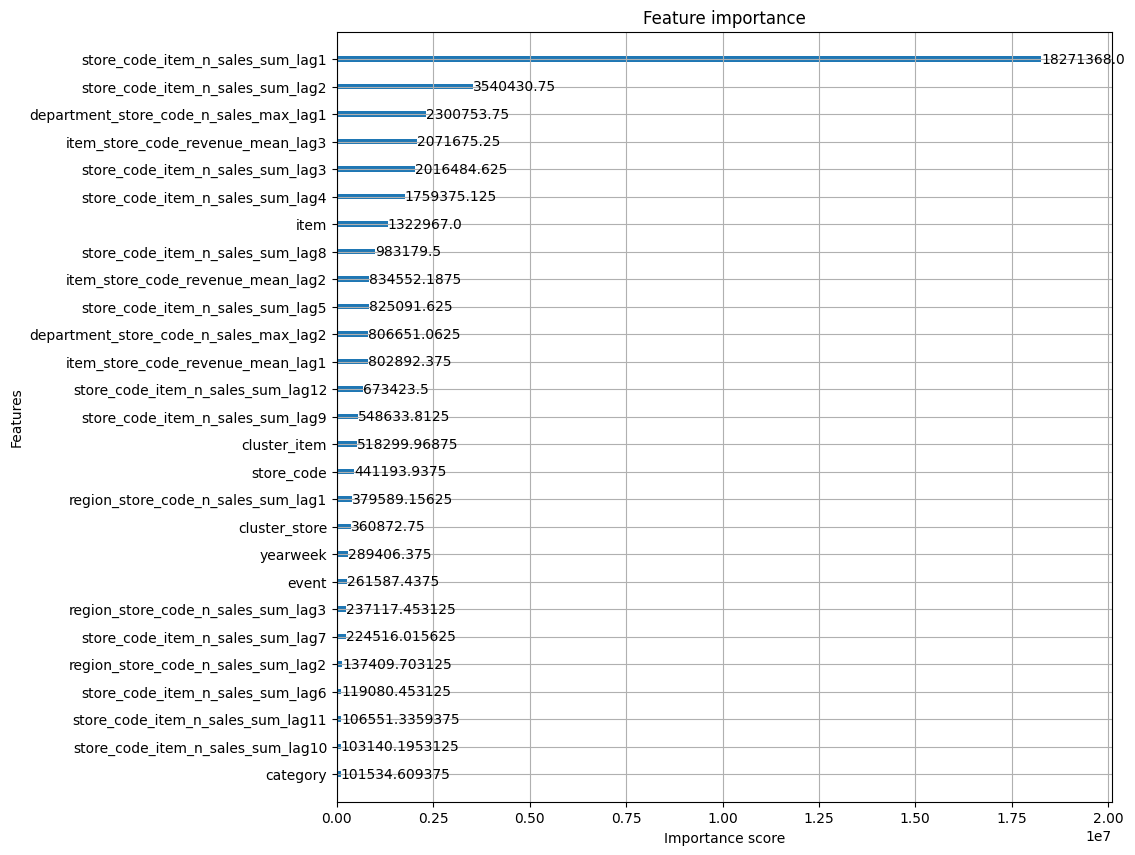

In [65]:
fig, ax = plt.subplots(figsize = (10, 10))
xgb.plot_importance(model, importance_type = "gain", ax = ax)